In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from scipy.constants import m_u, zero_Celsius
from scipy.constants import k as k_b

In [3]:
# Size of the box (m)
L = 100e-9
# Number of particles
N = 500
# Particle mass
m = 32 * m_u
# Temperature
T = 20 + zero_Celsius
# Time delta
dt = 1e-12
# How many iterations
iterations = 5000

time_array = np.linspace(0, dt*iterations, iterations)

In [4]:
def simulate(_N, _m, _T, _L, _dt, _iterations, _verbose=False):
    # Determine initial positions
    _positions = np.zeros((_N, _iterations, 3))
    _positions[:, 0] = np.random.rand(_N, 3) * _L
    # Determine initial velocities
    _velocities = np.zeros((_N, _iterations, 3))
    _velocities[:, 0] = np.random.normal(0, np.sqrt(k_b * _T / _m), (_N, 3))
    # Momentum transfer array
    _momenta = np.zeros((_N, iterations, 3))

    if _verbose:
        print(f'Average velocity: {np.mean(_velocities[:, 0]):.3f}')

    for i in range(1, iterations):
        # Update the position
        _positions[:, i] = _positions[:, i - 1] + _dt * _velocities[:, i - 1]
        # Initially copy over velocities
        _velocities[:, i] = _velocities[:, i - 1]

        # Calculate momentum transfer.
        _momenta[:, i, 0] = np.where((_positions[:, i, 0] > _L) | (_positions[:, i, 0] < 0), 2 * _m * np.abs(_velocities[:, i, 0]), 0)
        _momenta[:, i, 1] = np.where((_positions[:, i, 1] > _L) | (_positions[:, i, 1] < 0), 2 * _m * np.abs(_velocities[:, i, 1]), 0)
        _momenta[:, i, 2] = np.where((_positions[:, i, 2] > _L) | (_positions[:, i, 2] < 0), 2 * _m * np.abs(_velocities[:, i, 2]), 0)

        # Fix velocities, keeping let 'm bounce.
        _velocities[:, i, 0] = np.where((_positions[:, i, 0] > _L) | (_positions[:, i, 0] < 0), -_velocities[:, i, 0], _velocities[:, i, 0])
        _velocities[:, i, 1] = np.where((_positions[:, i, 1] > _L) | (_positions[:, i, 1] < 0), -_velocities[:, i, 1], _velocities[:, i, 1])
        _velocities[:, i, 2] = np.where((_positions[:, i, 2] > _L) | (_positions[:, i, 2] < 0), -_velocities[:, i, 2], _velocities[:, i, 2])

        # Fix positions based on boundaries.
        _positions[:, i, 0] = np.where(_positions[:, i, 0] < 0, -_positions[:, i, 0], _positions[:, i, 0])
        _positions[:, i, 0] = np.where(_positions[:, i, 0] > _L, 2*_L - _positions[:, i, 0], _positions[:, i, 0])

        _positions[:, i, 1] = np.where(_positions[:, i, 1] < 0, -_positions[:, i, 1], _positions[:, i, 1])
        _positions[:, i, 1] = np.where(_positions[:, i, 1] > _L, 2*_L - _positions[:, i, 1], _positions[:, i, 1])

        _positions[:, i, 2] = np.where(_positions[:, i, 2] < 0, -_positions[:, i, 2], _positions[:, i, 2])
        _positions[:, i, 2] = np.where(_positions[:, i, 2] > _L, 2*_L - _positions[:, i, 2], _positions[:, i, 2])

    _momenta = np.cumsum(np.sum(np.sum(_momenta, axis=2), axis=0))

    return _positions, _velocities, _momenta

positions, velocities, momenta = simulate(N, m, T, L, dt, iterations, True)

I notice that the average velocity is not 0. This is odd. When temperature goes to zero the average velocity goes to zero as well. As such I assume it is caused by the fact that N is not large enough.

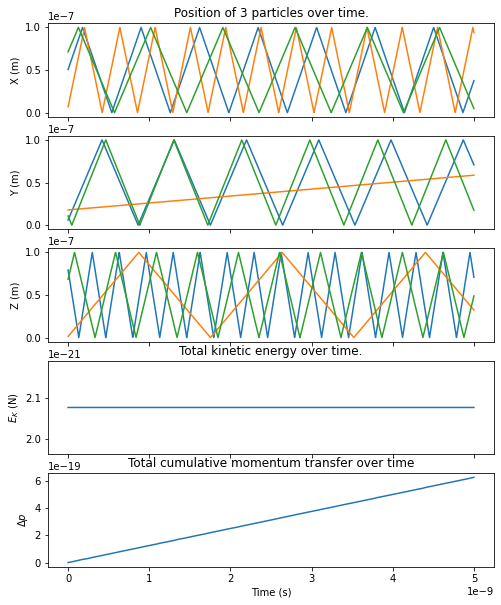

In [5]:
fig, axis = plt.subplots(5, 1, sharex='col')
fig.set_size_inches(8, 10)

axis[0].set_title('Position of 3 particles over time.')
for i in range(0, 3):
    axis[0].plot(time_array, positions[i, :, 0])
    axis[1].plot(time_array, positions[i, :, 1])
    axis[2].plot(time_array, positions[i, :, 2])

axis[0].set_ylabel('X (m)')
axis[1].set_ylabel('Y (m)')
axis[2].set_ylabel('Z (m)')

axis[3].plot(time_array, 0.5 * m * np.mean(np.mean(np.square(velocities), axis=2), axis=0))
axis[3].set_title('Total kinetic energy over time.')
axis[3].set_ylabel('$E_K$ (N)')

axis[4].plot(time_array, momenta)
axis[4].set_title('Total cumulative momentum transfer over time')
axis[4].set_ylabel('$\Delta p$')

axis[4].set_xlabel('Time (s)')
plt.show()

In [6]:
average_force = momenta[-1] / time_array[-1]
print(f'Average force: {average_force:.3e}')

Average force: 1.247e-10


In [7]:
pressure = average_force / (6 * L ** 2)
print(f'Pressure: {pressure:.3e}')

Pressure: 2.078e+03


Below you find the simulation for various values of T in a (P-V)-plot and for various values of V in a (P-T)-plot. It is not the most clean way to do it but I was short on time.

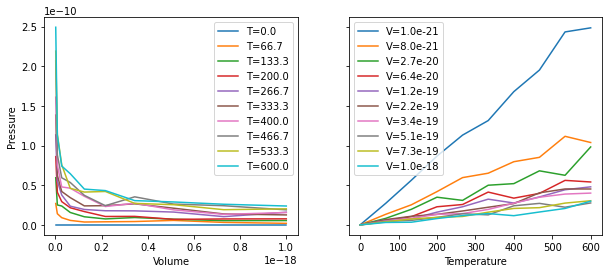

In [25]:
iterations = 100
time_array = np.linspace(0, dt*iterations, iterations)

fig, axis = plt.subplots(1, 2, sharey='row')
fig.set_size_inches(10, 4)
axis[0].set_ylabel('Pressure')
axis[0].set_xlabel('Volume')
axis[1].set_xlabel('Temperature')

temperatures = np.linspace(0, 600, 10)
sizes = np.linspace(L, 10*L, 10)
volumes = np.power(sizes, 3)

for temperature in temperatures:
    pressures = []

    for size in sizes:
        momenta = simulate(N, m, temperature, size, dt, iterations)[-1]
        pressures.append(momenta[-1] / time_array[-1])

    axis[0].plot(volumes, pressures, label=f'T={temperature:.1f}')

axis[0].legend()

for size in sizes:
    pressures = []

    for temperature in temperatures:
        momenta = simulate(N, m, temperature, size, dt, iterations)[-1]
        pressures.append(momenta[-1] / time_array[-1])

    axis[1].plot(temperatures, pressures, label=f'V={size**3:.1e}')

axis[1].legend()
plt.show()

We see that Pressure goes inversely over volume $P = \alpha \frac{1}{V}$. We furthermore see that pressure goes linearly with temperature ($P = \beta T$). This supports the the ideal gas law $PV = Nk_BT$.